In [2]:
"""
This is a the shrinkage version of Transport map. In this version, 
the regression functions $f_i$ and the niggest parameters $d_i$ are 
assumed to have some specific structures. These values are given by
the parametric covariance matrix. At the time being, no estimation
of the parametric covariance matrix is considered. In other words, 
we imply that all the parameters of the parametric covariance matrix
are known and does not need to be estimated. In latter versions, we
will consider the estimation of the parametric covariance matrix.


Author: Anirban Chakraborty,
Last modified: May 7, 2024
"""
%load_ext autoreload
%autoreload 2

### Load necessary libraries

In [3]:
import torch
import numpy as np
from veccs import orderings
from gpytorch.kernels import MaternKernel
from sklearn.gaussian_process import kernels
from matplotlib import pyplot as plt

from batram.helpers import make_grid, GaussianProcessGenerator
from batram.legmods import Data, SimpleTM
from batram.shrinkmods import ShrinkTM


/home/anirban0451/miniconda3/envs/climate/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Sample initial data

In [3]:
torch.manual_seed(20240507)

In [4]:
num_locs = 30; dim_locs = 2
nu_original = 0.5
length_scale_original = 0.3
numSamples = 30
sd_noise=1e-3

In [5]:
locs = make_grid(num_locs, dim_locs)
locsOriginal = make_grid(num_locs, dim_locs) #so that later ordering does not hurt

#sample data
gpkernel = kernels.Matern(nu=nu_original, length_scale=length_scale_original)
gp = GaussianProcessGenerator(locs=locs, kernel=gpkernel, sd_noise=sd_noise)
numpydata = gp.sample(num_reps=200)

### Plot sampled data

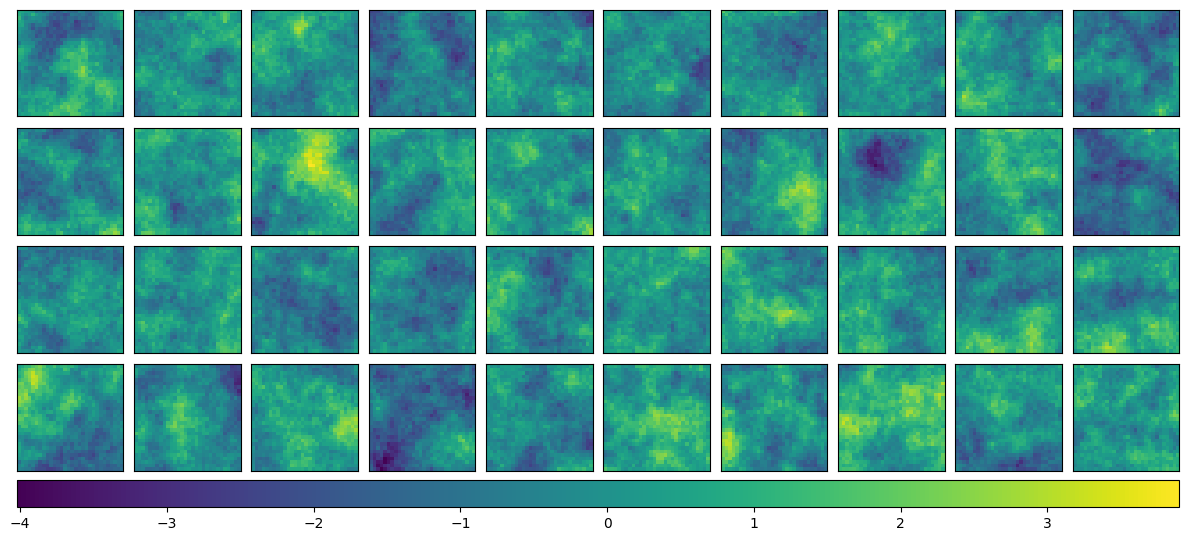

In [6]:
gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
vmin, vmax = numpydata[:40].min(), numpydata[:40].max()
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(numpydata[i].reshape(num_locs, num_locs), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Preprocess sampled data

In [7]:
torchdata = torch.from_numpy(numpydata).float() #converts into torch format
locsorder = orderings.maxmin_cpp(locs=locs) #find maxmin-ordeing

obs = torchdata[0:25, :] #snip first 10 samples
#obs = obs - obs.mean(dim=0, keepdim=True) #pixel-wise centering the data
obsTrain = obs
locs = locs[locsorder, ...]
obs = obs[..., locsorder]


largest_conditioning_set = 30
nn = orderings.find_nns_l2(locs, largest_conditioning_set)

# Create a `Data` object for use with the `SimpleTM`/ `ShrinkTM` model.
data = Data.new(torch.as_tensor(locs).float(), obs, torch.as_tensor(nn))


In [11]:
torch.save(
    {"master_data": torchdata,
     "locs_ordered": locs,
     "locs_original": locsOriginal,
     "locsorder": locsorder,
     "obs": obs,
     "nn": nn,
     "data": data,
     "gpGenerator": gp,
     "gpkernel": gpkernel,
    },
"../results/EXP900.pt")

### Calculate conditional means and variances for the parametric kernel (this would change in latter versions)

In [8]:
#gpkernel = kernels.Matern(nu=nu_original, length_scale=length_scale_original + 0.6)
parametric_mean_factors = torch.zeros((locs.shape[0], (data.augmented_response.shape[-1]-1)))
parametric_variances = torch.zeros(locs.shape[0])
parametric_variances[0] = 1

for i in range(1, locs.shape[0]):
    current_locs = locs[i, :]
    if i < largest_conditioning_set:
        previous_locs = locs[nn[i, 0:i], :]
    else:
        previous_locs = locs[nn[i], :]
    Sigma22 = torch.from_numpy(gpkernel(previous_locs, previous_locs)) + (sd_noise ** 2) * torch.eye(previous_locs.shape[0])
    Sigma12 = torch.from_numpy(gpkernel(current_locs, previous_locs))
    Sigma22inv = torch.linalg.solve(Sigma22, torch.eye(previous_locs.shape[0], dtype=torch.double))
    parametric_mean_factors[i, 0:min(i, largest_conditioning_set)] = Sigma12 @ Sigma22inv
    parametric_variances[i] = 1 - Sigma12 @ Sigma22inv @ Sigma12.T

### Fitting the shrinkage TM

In [9]:
shrink_tm = ShrinkTM(data, theta_init=None, linear=False, 
                     smooth=1.5, 
                     shrinkage_mean_factor=parametric_mean_factors,
                     shrinkage_var=parametric_variances)

In [10]:
nsteps = 2000
opt = torch.optim.Adam(shrink_tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res2 = shrink_tm.fit(
    nsteps, 0.1, test_data=shrink_tm.data, optimizer=opt, scheduler=sched, batch_size=300
)

Train Loss: -11878.323, Test Loss: -11878.332:  16%|█▋        | 327/2000 [00:22<01:53, 14.70it/s]


KeyboardInterrupt: 

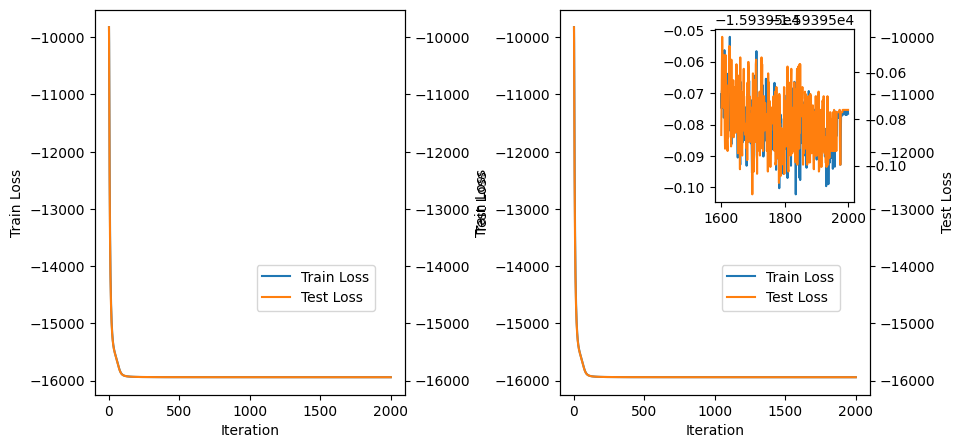

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"wspace": 0.5})
res2.plot_loss(axs[0], use_inset=False)
res2.plot_loss(axs[1], use_inset=True)
plt.show()

In [ ]:
new_sample = shrink_tm.cond_sample(num_samples=40)#[0, ...]


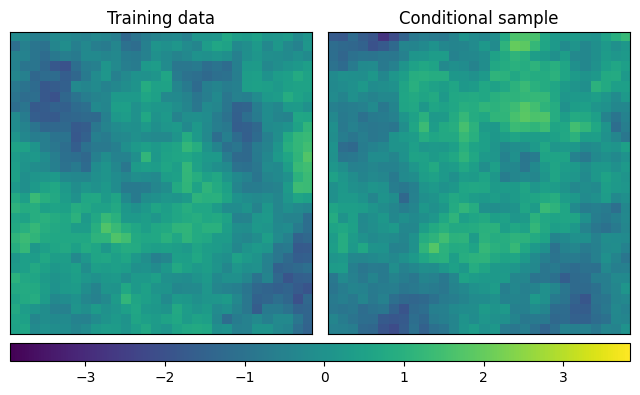

In [ ]:
# Compare the resampled field with the training data
vmin, vmax = new_sample[:40].min(), new_sample[:40].max()
gspec = {"wspace": 0.05}
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=gspec, squeeze=True)

# Plot the training data
ax[0].imshow(obs[5, locsorder.argsort()].reshape(num_locs, num_locs), vmin=vmin, vmax=vmax)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Training data")


# Plot the conditionally resampled field (sample 2)
im = ax[1].imshow(new_sample[0,locsorder.argsort()].reshape(num_locs, num_locs), vmin=vmin, vmax=vmax)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Conditional sample")

fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

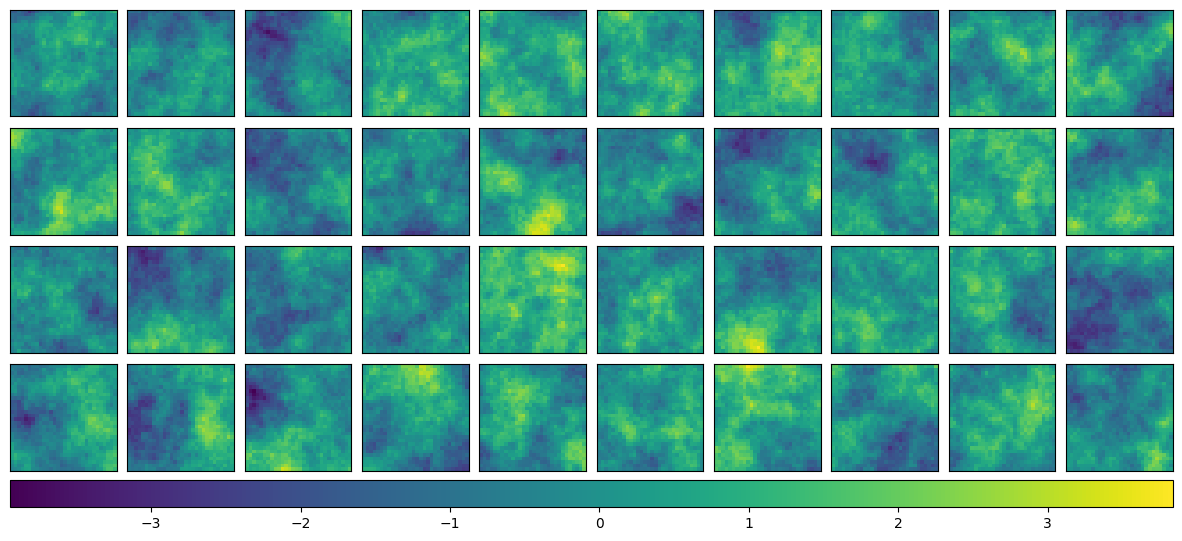

In [ ]:
gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
vmin, vmax = new_sample[:40].min(), new_sample[:40].max()
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(new_sample[i, locsorder.argsort()].reshape(num_locs, num_locs), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Comparing log-score with the base transport maps (needs re-running of few developed  optimizations early in the notebook)

In [4]:
torch.manual_seed(20240507)

In [5]:
## kernel and location parameters

num_locs = 30; dim_locs = 2
nu_original = 0.5
length_scale_original = 0.3
numSamples = 30
sd_noise=1e-3
largest_conditioning_set = 30

In [6]:
## generate data

locs = make_grid(num_locs, dim_locs)

#sample data
gpkernel = kernels.Matern(nu=nu_original, length_scale=length_scale_original)
gp = GaussianProcessGenerator(locs=locs, kernel=gpkernel, sd_noise=sd_noise)
numpydata = gp.sample(num_reps=200)

In [7]:
## ordering the locations

locsorder = orderings.maxmin_cpp(locs=locs) #find maxmin-ordeing
locs = locs[locsorder, ...]
nn = orderings.find_nns_l2(locs, largest_conditioning_set)

In [8]:
## defining the weights of shrinkage kernel

parametric_mean_factors = torch.zeros((locs.shape[0], largest_conditioning_set))
parametric_variances = torch.zeros(locs.shape[0])
parametric_variances[0] = 1

for i in range(1, locs.shape[0]):
    current_locs = locs[i, :]
    if i < largest_conditioning_set:
        previous_locs = locs[nn[i, 0:i], :]
    else:
        previous_locs = locs[nn[i], :]
    Sigma22 = torch.from_numpy(gpkernel(previous_locs, previous_locs)) + (sd_noise ** 2) * torch.eye(previous_locs.shape[0])
    Sigma12 = torch.from_numpy(gpkernel(current_locs, previous_locs))
    Sigma22inv = torch.linalg.solve(Sigma22, torch.eye(previous_locs.shape[0], dtype=torch.double))
    parametric_mean_factors[i, 0:min(i, largest_conditioning_set)] = Sigma12 @ Sigma22inv
    parametric_variances[i] = 1 - Sigma12 @ Sigma22inv @ Sigma12.T

In [12]:
## getting the data ready

torchdata = torch.from_numpy(numpydata).float() #converts into torch format
torchdata = torchdata[:, locsorder]
numSamples = [2, 3, 5, 10, 15, 20, 25, 30]
neglogScore_tm = torch.zeros(len(numSamples))
neglogScore_shrink = torch.zeros(len(numSamples))
tm_models = []
shrink_models = []


In [13]:
## fit models
for i, n in enumerate(numSamples):
    obs = torchdata[0:n, :] #snip first n samples
    #if obs.dim() == 1:
    #    obs = obs.unsqueeze(0)
    obsTrain = obs
    obs = obs[..., locsorder]

    # Create a `Data` object for use with the `SimpleTM`/ `ShrinkTM` model.
    data = Data.new(torch.as_tensor(locs).float(), obs, torch.as_tensor(nn))

    tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)
    nsteps = 2000
    opt = torch.optim.Adam(tm.parameters(), lr=0.01)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
    res = tm.fit(
        nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=300
    )
    tm_models.append(tm)
    
    shrink_tm = ShrinkTM(data, theta_init=None, linear=False, 
                     smooth=1.5, 
                     shrinkage_mean_factor=parametric_mean_factors,
                     shrinkage_var=parametric_variances)
    opt2 = torch.optim.Adam(shrink_tm.parameters(), lr=0.01)
    sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, nsteps)
    res2 = shrink_tm.fit(
        nsteps, 0.1, test_data=shrink_tm.data, optimizer=opt2, scheduler=sched2, batch_size=300
    )
    shrink_models.append(shrink_tm)

    for _j in range(0, 50):
        with torch.no_grad():
            neglogScore_tm[i] += tm.score(torchdata[(100 + _j), :])
        neglogScore_shrink[i] += shrink_tm.score(torchdata[(100 + _j), :])
    

Train Loss: 10175.748, Test Loss: 10175.748: 100%|██████████| 2000/2000 [02:25<00:00, 13.76it/s]


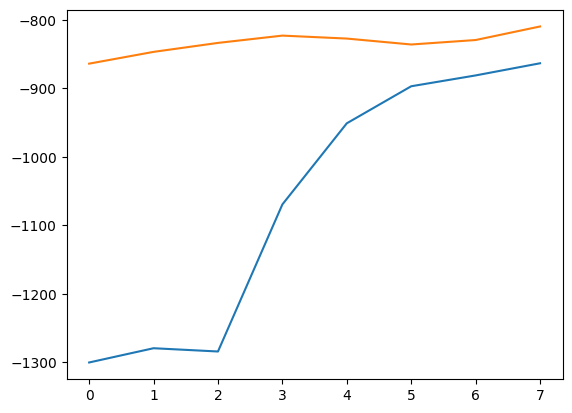

In [16]:
plt.plot(torch.arange(len(numSamples)), neglogScore_tm/50)
plt.plot(torch.arange(len(numSamples)), neglogScore_shrink/50)

In [15]:
torch.save({
    "tm_models": tm_models,
    "shrink_models": shrink_models,
    "tm_logscore" : neglogScore_tm,
    "shrink_logscore": neglogScore_shrink
}, "../results/initial_experiments.pt")

### Wokring with estimate ShrinkTM (where the parametric kernel needs to be estimated)

In [ ]:
from batram.shrinkmods import EstimableShrinkTM

full_data = torch.load("../results/EXP900.pt")